In [ ]:
# Import necessary packages
from astropy import units as u
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import astropy.io.ascii
%matplotlib inline
from scipy.optimize import curve_fit
from astropy import constants as ac

In [ ]:
# Load the drive helper and mount
#from google.colab import drive

# This will prompt for authroities
#drive.mount("/content/drive/")

base_path = '' #"/content/drive/MyDrive/Astron_5205/"

In [ ]:
# Measuring the min mass of HD 189733 b from RV data

In [ ]:
file_path = base_path + "HD189733b_RVC.txt"

# Read the file manually, filtering out comment and header lines
data = []
with open(file_path, "r") as file:
    for line in file:
        if not line.startswith(("\\", "|")):  # Skip metadata and header lines
            parts = line.split()
            data.append([float(parts[0]), float(parts[1]), float(parts[2])])

# Convert to NumPy array
rv_data = np.array(data)

# Extract columns
jd = rv_data[:, 0]       # Julian Date
rv = rv_data[:, 1]       # Radial Velocity (m/s)
rv_err = rv_data[:, 2]   # Radial Velocity Uncertainty (m/s)

print(jd[:5], rv[:5], rv_err[:5])  # Print first 5 rows for verification

[2452832.881794 2452898.800937 2453180.918877 2453240.898507
 2453303.750382] [ -13.964  186.717  153.226  121.542 -202.928] [1.542 1.48  1.609 1.139 1.244]


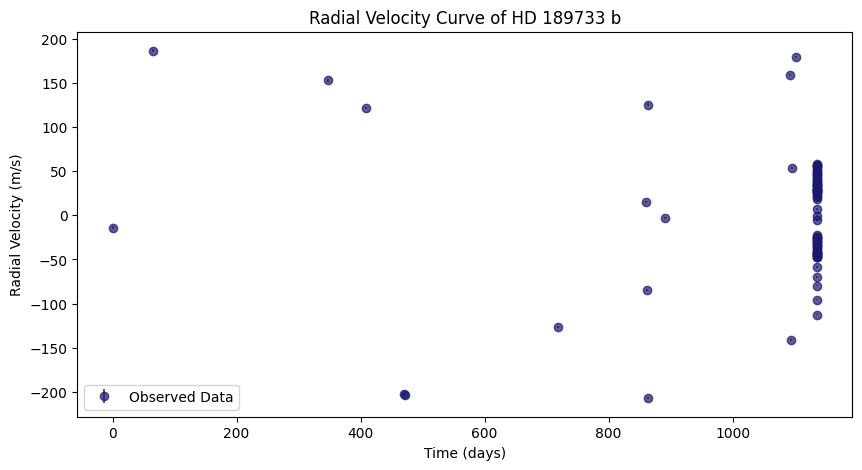

In [ ]:
# Convert to numpy arrays
jd = np.array(jd)
rv = np.array(rv)
rv_err = np.array(rv_err)

# Normalize time (shift JD to start from zero for better fitting)
jd -= jd.min()

# Plot radial velocity data
plt.figure(figsize=(10, 5))
plt.errorbar(jd, rv, yerr=rv_err, fmt="o", color = "midnightblue", label="Observed Data", alpha=0.7)
plt.xlabel("Time (days)")
plt.ylabel("Radial Velocity (m/s)")
plt.title("Radial Velocity Curve of HD 189733 b")
plt.legend()
plt.show()

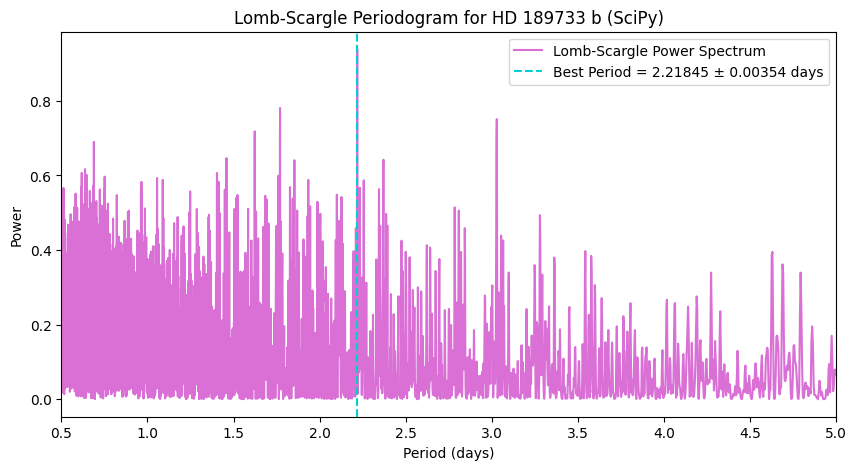

Estimated period from Lomb-Scargle: 2.21845 ± 0.00354 days


In [ ]:
from scipy.signal import lombscargle

#Define frequency range for Lomb-Scargle
min_period = 0.5 # Shortest period to search (days)
max_period = 5.0 # Longest period to search (days)
frequencies = np.linspace(1 / max_period, 1 / min_period, 10000) # Convert periods to frequency

# Convert to angular frequency
angular_frequencies = 2 * np.pi * frequencies

# Compute Lomb-Scargle power spectrum (normalized)
power = lombscargle(jd, rv, angular_frequencies, normalize=True) # SciPy version

# Find best period
best_frequency = frequencies[np.argmax(power)]
P_lomb_scipy = 1 / best_frequency

#--- Estimate Period Uncertainty ---
half_max = np.max(power) / 2 # Half-max power threshold
peak_idx = np.argmax(power) # Index of highest power

# Find left and right frequency indices where power drops below half max
left_idx = np.where(power[:peak_idx] < half_max)[0][-1]
right_idx = np.where(power[peak_idx:] < half_max)[0][0] + peak_idx

# Compute FWHM width in frequency space
fwhm_frequency = frequencies[right_idx] - frequencies[left_idx]

# Convert to period uncertainty
P_err = (1 / (best_frequency - fwhm_frequency / 2)) - (1 / (best_frequency + fwhm_frequency / 2))

#--- Plot Periodogram ---
plt.figure(figsize=(10, 5))
plt.plot(1 / frequencies, power, color="orchid", label="Lomb-Scargle Power Spectrum")
plt.axvline(P_lomb_scipy, color="darkturquoise", linestyle="--", label=f"Best Period = {P_lomb_scipy:.5f} ± {P_err:.5f} days")

plt.xlabel("Period (days)")
plt.ylabel("Power")
plt.title("Lomb-Scargle Periodogram for HD 189733 b (SciPy)")
plt.legend()
plt.xlim(min_period, max_period)
plt.show()

# Print results
print(f"Estimated period from Lomb-Scargle: {P_lomb_scipy:.5f} ± {P_err:.5f} days")

In [ ]:
K_est = (rv.max() - rv.min()) / 2 # m/s # Rough estimate of semi-amplitude
K_err = np.mean(rv_err)
print("Estimated Semi-amplitude:", K_est)
print(f"Estimated Semi-amplitude: {K_est:.5f} ± {K_err:.5f} m/s")

Estimated Semi-amplitude: 196.8555
Estimated Semi-amplitude: 196.85550 ± 0.90605 m/s


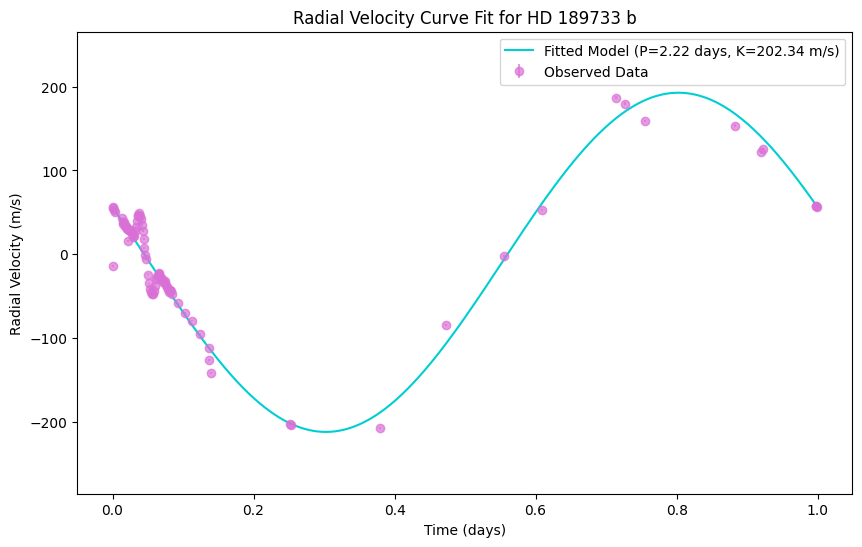

In [ ]:
# Define a sinusoidal function for fitting
def rv_model(t, K, phi, offset):
    """ Radial velocity model: sinusoidal function """
    return K * np.sin(2 * np.pi * t + phi) + offset

# Redifine the time as the phase
jd_phase = (jd % P_lomb_scipy) / P_lomb_scipy  # Phase-folded time

# Estimate initial values for fitting
K_est = (rv.max() - rv.min()) / 2  # m/s
phi_est = 0  # Initial phase
offset_est = np.mean(rv)  # Offset (systemic velocity)

# Fit the radial velocity data
popt, pcov = curve_fit(rv_model, jd_phase, rv, p0=[K_est, phi_est, offset_est])

# Extract best-fit parameters
K_fit, phi_fit, offset_fit = popt
K_fit = np.abs(K_fit)

# Generate fitted curve
jd_fit = np.linspace(jd_phase.min(), jd_phase.max(), 500)
rv_fit = rv_model(jd_fit, *popt)

# Plot observed data and fitted curve
plt.figure(figsize=(10, 6))
plt.errorbar(jd_phase, rv, yerr=rv_err, fmt="o", color='orchid', label="Observed Data", alpha=0.7)
plt.plot(jd_fit, rv_fit, label=f"Fitted Model (P={P_lomb_scipy:.2f} days, K={K_fit:.2f} m/s)", color="darkturquoise")

#plt.style.use('dark_background')
#matplotlib.rcParams['axes.edgecolor'] = 'white'
plt.tick_params(axis='x')
plt.tick_params(axis='y')

plt.ylim(rv.min() - 0.2 * (rv.max() - rv.min()), rv.max() + 0.2 * (rv.max() - rv.min()))
plt.xlabel("Time (days)")
plt.ylabel("Radial Velocity (m/s)")
plt.title("Radial Velocity Curve Fit for HD 189733 b")
plt.legend(loc='best')
plt.show()

In [ ]:
# Constants
G = ac.G  # Gravitational constant (m^3/kg/s^2)
M_sun = ac.M_sun  # Mass of the Sun (kg)
M_jupiter = ac.M_jup  # Mass of Jupiter (kg)

# Given mass of HD 189733 (stellar mass ~0.82 M_sun)
M_star = 0.82 * M_sun

# Convert period from days to seconds
P_seconds = P_lomb_scipy * 24 * 3600

# Compute minimum mass (m_p sin i)
mp_sini = (K_fit * (P_seconds ** (1/3)) * (M_star ** (2/3))) / ((2 * np.pi * G) ** (1/3))

# Convert to Jupiter masses
mp_sini_Mjup = mp_sini / M_jupiter

# Print results
print(f"Radial velocity amplitude (K): {K_fit:.2f} m/s")
print(f"Orbital period (P): {P_lomb_scipy:.2f} days")
print(f"Minimum exoplanet mass (m_p sin i): {mp_sini:.2e} kg ({mp_sini_Mjup:.2f} M_Jup)")

Radial velocity amplitude (K): 202.34 m/s
Orbital period (P): 2.22 days
Minimum exoplanet mass (m_p sin i): 2.16e+27 kg s(2/3) / m kg (1.14 s(2/3) / m M_Jup)


In [ ]:
# The actual minimum mass is 1.13M_Jup = 2.14474e27 m --> Pretty close!!

In [ ]:
# Measuring radius of HD 189733 b from transit data

In [ ]:
file_path = base_path + "HD189733b_LC.txt"

# Read the file manually, filtering out comment and header lines
data = []
with open(file_path, "r") as file:
    for line in file:
        if not line.startswith(("\\", "|")):  # Skip metadata and header lines
            parts = line.split()
            data.append([float(parts[0]), float(parts[1]), float(parts[2])])

# Convert to NumPy array
lc_data = np.array(data)

# Extract columns
jd_lc = lc_data[:, 0]       # Julian Date
lc = lc_data[:, 1]       # Relative Flux double
lc_err = lc_data[:, 2]   # Relative flux Uncertainty double

print(jd_lc[:5], lc[:5], lc_err[:5])  # Print first 5 rows for verification

[2453988.70219 2453988.70235 2453988.70251 2453988.70267 2453988.70285] [1.0034 1.0055 1.003  0.9995 0.9969] [0.0017 0.0017 0.0017 0.0017 0.0017]


<ipython-input-59-e1e2a00b1fb2>:13: OptimizeWarning: Covariance of the parameters could not be estimated
  best_params, covariance = curve_fit(transit_model, jd_lc, lc, p0=initial_guess)


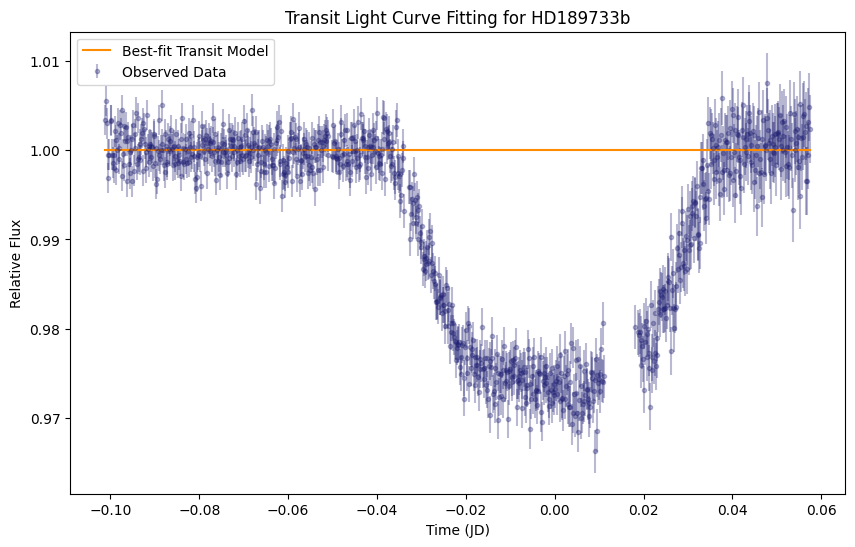

Best-fit Transit Midpoint: 2453988.80331 JD
Best-fit Transit Depth: 0.03370
Best-fit Transit Duration: 0.07500 days


In [ ]:
# Define a simple box transit model
def transit_model(t, t0, depth, duration):
    """Simple box-like transit model."""
    model = np.ones_like(t)
    in_transit = np.abs(t - t0) < (duration / 2)
    model[in_transit] = 1 - depth
    return model

# Initial parameter estimates
initial_guess = [2453988.80331, 0.0337, 0.075]  # t0, depth, duration

# Fit model to data
best_params, covariance = curve_fit(transit_model, jd_lc, lc, p0=initial_guess)

# Generate best-fit model
best_fit_curve = transit_model(jd_lc, *best_params)

# Plot results
plt.figure(figsize=(10, 6))
plt.errorbar(jd_lc, lc, yerr=lc_err, fmt='o', markersize=3, label='Observed Data', color='midnightblue', alpha=0.3)
plt.plot(jd_lc, best_fit_curve, color='darkorange', label='Best-fit Transit Model')
plt.xlabel('Time (JD)')
plt.ylabel('Relative Flux')
plt.legend()
plt.title('Transit Light Curve Fitting for HD189733b')
plt.show()

# Print best-fit parameters
t0_best, depth_best, duration_best = best_params
print(f"Best-fit Transit Midpoint: {t0_best:.5f} JD")
print(f"Best-fit Transit Depth: {depth_best:.5f}")
print(f"Best-fit Transit Duration: {duration_best:.5f} days")

In [ ]:
# This looks gross, so I'm gonna try Ji's method. --> Nvm, the pylightcurve package is a pain to download. Using Batman instead.

In [ ]:
# pip install batman-package

In [ ]:
# Finding a/R_s value
R_sun = ac.R_sun # Solar radius in m
R_s = 0.75 * R_sun
R_a = 0.1124
a = R_s / R_a
print(a.to(u.R_sun))

6.672597864768683 solRad


In [ ]:
# Finding a/R_s value cont.
a_R = a / R_s
print(a_R)

8.896797153024911


In [ ]:
pip install batman-package

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 399.3/399.3 kB 5.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for batman-package: filename=batman_package-2.5.2-cp311-cp311-linux_x86_64.whl size=186618 sha256=fdcba1dae95517a155e9f4b7a8b5feb4b11f3fba2ccbcf0460f451eba0b34198
  Stored in directory: /root/.cache/pip/wheels/83/d5/e7/38d6ea89c60649c4fe3ed4f933f80f85bd416b8111977aeb99
Successfully built batman-package


In [ ]:
import batman as bm # Importing batman for transit modeling
from batman import TransitParams, TransitModel

# Center time around transit midpoint to improve fitting stability
transit_midpoint = 2453988.80331
jd_lc = [i - transit_midpoint for i in lc_data[:, 0] ]

# Define transit model function for fitting
def transit_model(time, t0, rp, a, inc):
    params = bm.TransitParams()
    params.t0 = t0  # Time of inferior conjunction (centered time)
    params.per = 2.218573  # Fixed orbital period (days)
    params.rp = rp  # Planet radius (Rp/Rs)
    params.a = a  # Semi-major axis (a/Rs)
    params.inc = inc  # Orbital inclination (degrees)
    params.ecc = 0.0  # Assume circular orbit
    params.w = 90.0  # Argument of periastron (degrees)
    params.limb_dark = "nonlinear"
    params.u = [0.5, 0.1, 0.1, -0.1]  # Example limb darkening coefficients

    m = bm.TransitModel(params, np.array(time))  # Use the times for each point
    return m.light_curve(params) # the modeled flux from the given parameters



# Initial parameter estimates for fitting
initial_guess = [ 0.0, 0.1575, 8.896797153024911, 86.1]  # Centered t0, rp_over_rs, sma_over_rs, inclination (degrees), values
                                                            # from literature
#param_bounds = ([ -0.1, 0.05, 15.0],  # Lower bounds (realistic values)
                #[  0.1, 0.10, 30.0])  # Upper bounds
                                      # Note: I stopped using these bounds, and it worked better, it seemed to lie just outside of the bounds
# Fit the model to the data
try:
    best_params, covariance = curve_fit(transit_model, jd_lc, lc, p0=initial_guess,
                                        sigma=lc_err, absolute_sigma=True)
    t = np.linspace(min(jd_lc), max(jd_lc), 10000)
    best_fit_curve = transit_model(t, *best_params)
except RuntimeError:
    print("Error: Curve fitting did not converge.")
    best_params = initial_guess  # Use initial guess if fit fails
    best_fit_curve = transit_model(jd_lc, *best_params)

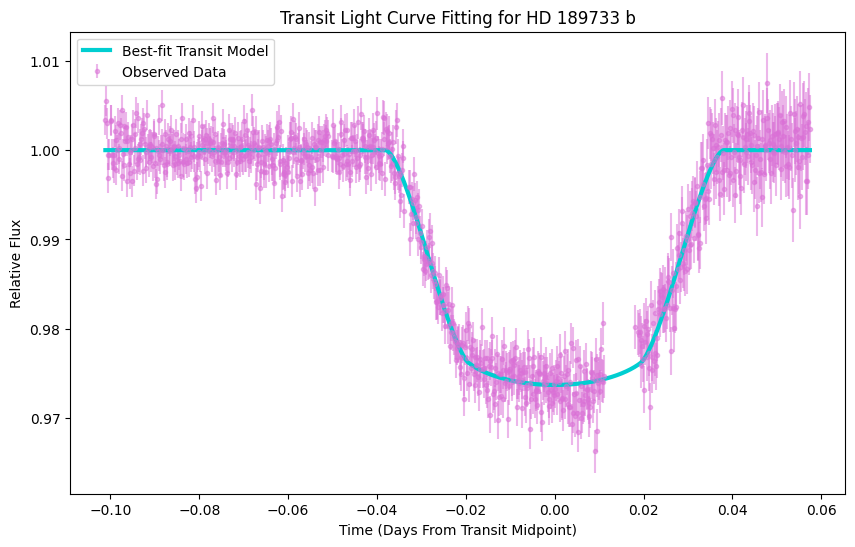

Best-fit Transit Midpoint Offset: -0.00001 days
Best-fit Planet Radius (Rp/Rs): 0.15966
Best-fit Semi-Major Axis (a/Rs): 8.69503
Best-fit inclination Axis (degrees): 85.44530


In [ ]:
# Plot results
plt.figure(figsize=(10, 6))
plt.errorbar(jd_lc, lc, yerr=lc_err, fmt='o', markersize=3, label='Observed Data', color='orchid', alpha=0.5)
plt.plot(t, best_fit_curve, color='darkturquoise', lw=3, label='Best-fit Transit Model')
plt.xlabel('Time (Days From Transit Midpoint)')
plt.ylabel('Relative Flux')
plt.legend()
plt.title('Transit Light Curve Fitting for HD 189733 b')
plt.tick_params(axis='x')
plt.tick_params(axis='y')
plt.show()

# Print best-fit parameters
t0_best, rp_best, a_best, inc_best = best_params
print(f"Best-fit Transit Midpoint Offset: {t0_best:.5f} days")
print(f"Best-fit Planet Radius (Rp/Rs): {rp_best:.5f}")
print(f"Best-fit Semi-Major Axis (a/Rs): {a_best:.5f}")
print(f"Best-fit inclination Axis (degrees): {inc_best:.5f}")

In [ ]:
# Finding radius error
# Error for all four parameters --> radius si the 2nd one
param_err = np.sqrt(np.diag(covariance))
print(param_err)

[1.19751448e-04 7.39703040e-04 1.33648325e-01 1.47675163e-01]


In [ ]:
# Constants
R_sun = ac.R_sun # Solar radius in m
R_jupiter = ac.R_jup # Jupiter radius in m

# Given stellar radius from literature
R_star = 0.75 * R_sun  # Radius of HD 189733

# Transit depth from light curve metadata
delta = 1 - np.min(lc)  # Transit depth

# Compute exoplanet radius
R_p = R_star * np.sqrt(delta) # Radius in m
R_p_Rj = R_p / R_jupiter  # Convert to Jupiter radii

print(f"Exoplanet Radius: {R_p:.2f}  ({R_p_Rj:.2f} R_J)")

# from the fit above
R_p_fit = R_star * best_params[1]
R_p_Rj = R_p_fit / R_jupiter  # Convert to Jupiter radii

print(f"Exoplanet Radius: {R_p_fit:.2f}  ({R_p_Rj:.2f} R_J)")

Exoplanet Radius: 95785157.39 m  (1.34 R_J)
Exoplanet Radius: 83308116.01 m  (1.17 R_J)


In [ ]:
# The actual radius is 1.13R_Jup = 80785960 m --> Getting it from the fit makes it much more accurate!

In [ ]:
R_act = 80785960 * u.m # Actual radius in m
R_diff = R_p_fit - R_act
print(f"Difference between experimental radius and actual radius is", R_diff)

Difference between experimental radius and actual radius is 2522156.0066577494 m


In [ ]:
# Finding the density from radius and min mass measurements

In [ ]:
# Mass of HD 189733 b (kg)
M_p = 2.20e27  # From radial velocity analysis

# Radius of HD 189733 b (m)
R_p_fit = 83308363.60 # From transit data

# Compute density (kg/m³)
rho_p = M_p / ((4/3) * np.pi * R_p_fit**3)

print(f"Density of HD 189733 b: {rho_p:.2f} kg/m³")

Density of HD 189733 b: 908.38 kg/m³


In [ ]:
# The actual density
# Mass of HD 189733 b (kg)
M_act = 2.14474e27  # From NASA

# Radius of HD 189733 b (m)
R_act = 80785960  # From transit data

# Compute density (kg/m³)
rho_act = M_act / ((4/3) * np.pi * R_act**3)

print(f"Actual density of HD 189733 b: {rho_act:.2f} kg/m³")

Actual density of HD 189733 b: 971.13 kg/m³


In [ ]:
rho_diff = rho_act - rho_p
print(f"Difference between experimental density verses the actual density", rho_diff, "kg/m³")

Difference between experimental density verses the actual density 62.75078253799779 kg/m³


In [ ]:
# The difference is most likely occurring due to the discrepancy with the radius.

In [ ]:
# Calculating the total uncertainties

In [ ]:
# Mass
# Constants
G = ac.G  # Gravitational constant (m^3/kg/s^2)
M_sun = ac.M_sun  # Mass of the Sun in kg
P = 2.218573 * u.day # Orbital period in days
P_err = 0.00354 * u.day# Uncertainty in days, calculated myself
M_s = 0.82 * M_sun # Stellar mass in kg
M_s_err = 0.03 * u.kg # Uncertainty in kg, from the literature
R_s = 0.75 * R_sun # Stellar radius in m
R_s_err = 0.02 * u.m# Uncertainty in m, from the literature
K = K_fit * u.m / u.s # Semi-amplitude in m/s, calculated myself
K_err = np.sqrt(np.diag(pcov))[0] * u.m / u.s # Uncertainty in m/s, calculated myself

# Compute planetary mass using:
# M_p * sin(i) = (K * M_s^(2/3) * P^(1/3)) / (2πG)^(1/3)
M_p = mp_sini.value * u.kg
M_p_jup = M_p / M_jupiter

# Uncertainty propagation for M_p
M_p_err = M_p * (np.sqrt((K_err / K) ** 2 +(2/3 * M_s_err / M_s) ** 2 + (1/3 * P_err / P) ** 2))
M_p_err_jup = M_p_err / M_jupiter
print(f"Estimated Planet Mass: {M_p:.3e} ± {M_p_err:.3e} ")
print(f"Estimated Planet Mass: {M_p_jup:.3f} ± {M_p_err_jup:.3f} M_J")

# Radius
# Since the radius is derived from the transit depth, then its uncertainty is propagated from the uncertainties of the transit depth
#  and stellar radius.
# Compute transit depth and its uncertainty
td = 1 - np.min(lc)  # Depth = 1 - minimum flux
td_err = np.mean(lc_err)  # Approximate uncertainty

# Compute planetary radius using:
R_p = R_s * best_params[1] # Radius in m
R_p_jup = R_p / R_jupiter # Radius in Jupiter radii

# Uncertainty propagation for R_p
R_p_err =  param_err[1] * R_s # uncertainty in m
R_p_err_jup = R_p_err / R_jupiter # uncertainty in Jupiter radii

print(f"Estimated Planet Radius: {R_p:.3e}  ± {R_p_err:.3e} ")
print(f"Estimated Planet Radius: {R_p_jup:.3f}  ± {R_p_err_jup:.3f} R_J")

# Density
rho = M_p / ((4/3) * np.pi * R_p**3)

# Uncertainty propagation for density
rho_err = rho * np.sqrt((M_p_err / M_p) ** 2 +(3 * R_p_err / R_p) ** 2)
print(f"Estimated Density: {rho:.3f} ± {rho_err:.3f} ")

Estimated Planet Mass: 2.159e+27 kg ± 5.869e+25 kg 
Estimated Planet Mass: 1.138 ± 0.031 M_J
Estimated Planet Radius: 8.331e+07 m  ± 3.860e+05 m 
Estimated Planet Radius: 1.165  ± 0.005 R_J
Estimated Density: 891.513 kg / m3 ± 27.219 kg / m3 


In [ ]:
# Our numbers are close, but not quite, so it's somewhat unreasonable for our uncertainties to be s low.
# Mention in the slides and paper.

In [ ]:
# Sources
# https://arxiv.org/pdf/astro-ph/0609506
# https://arxiv.org/pdf/astro-ph/0612224

In [ ]:
mp_sini

<Quantity 2.15912838e+27 kg s(2/3) / m>